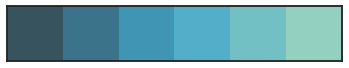

In [12]:
import pysolr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

sns.set(style="white", context="talk")
sns.palplot(sns.color_palette("GnBu_d"))

rcParams['figure.figsize'] = 11.7,11.7


solrcon = pysolr.Solr('http://192.168.56.102:8983/solr/movies_indexed', timeout=100)

In [13]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

# Genres revenue and ratings

In [14]:
results = solrcon.search('*:*', fq=['revenue:[1 TO *]', 'genres:["" TO *]'], rows=50000)
movies_with_revenue_query = pd.DataFrame(results.docs)
print(len(movies_with_revenue_query))
movies_with_revenue_query

7353


,_version_,adult,budget,genres,id,keywords,movie_id,original_language,original_title,overview,popularity,production_companies,production_countries,rating,release_date,revenue,spoken_languages,title
0,1672701158702972928,[False],[54000000],"[Action, Thriller, Fantasy]",a85fbdad-adfe-4459-bc0f-38128001acd9,"[detective, vatican, fascism, satanism, fascis...",[752],[en],[V for Vendetta],[In a world in which Great Britain has become ...,[20.214422],"[Studio Babelsberg, DC Comics, Virtual Studios...","[Germany, United Kingdom, United States of Ame...",[3.9198477],[2006-03-15T00:00:00Z],[132511035],[English],[V for Vendetta]
1,1672701158745964544,[False],[250000000],"[Adventure, Fantasy, Family]",2d0eb97a-1163-4922-b6b2-fc71e003c062,"[witch, magic, broom, school of witchcraft, wi...",[767],[en],[Harry Potter and the Half-Blood Prince],"[As Harry begins his sixth year at Hogwarts, h...",[19.083723],"[Warner Bros., Heyday Films]","[United Kingdom, United States of America]",[3.8431253],[2009-07-07T00:00:00Z],[933959197],[English],[Harry Potter and the Half-Blood Prince]
2,1672701158748061696,[False],[1000000],[Horror],dbb14a24-d1ca-4b95-9a38-50a24b140a84,"[prophecy, sea, beach, gold, small town, behea...",[790],[en],[The Fog],[Strange things begin to occurs as a tiny Cali...,[9.194572],"[AVCO Embassy Pictures, EDI, Debra Hill Produc...",[United States of America],[3.0338051],[1980-02-08T00:00:00Z],[21378361],[English],[The Fog]
3,1672701158752256000,[False],[110000000],"[Action, Adventure, Comedy, Family, Fantasy]",22f972ac-ae49-4863-acf6-91a6dbdfecb2,"[museum, skeleton, night shift, chaos, genghis...",[1593],[en],[Night at the Museum],[Chaos reigns at the natural history museum wh...,[16.661966],"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",[3.0549178],[2006-10-20T00:00:00Z],[574480841],"[English, Italiano, עִבְרִית]",[Night at the Museum]
4,1672701158756450304,[False],[30000000],"[Action, Adventure, Crime]",312ce680-2213-4d37-b24f-c59da4690a9c,"[bomb, airport, bus, bus ride, highway, bomb p...",[1637],[en],[Speed],[Los Angeles SWAT cop Jack Traven is up agains...,[10.859292],[Twentieth Century Fox Film Corporation],[United States of America],[3.4874077],[1994-06-09T00:00:00Z],[350448145],[English],[Speed]
5,1672701158763790336,[False],[16000000],[Drama],bb9b429c-a65d-463c-91bf-651933c961cb,"[sadness, loss of father, junkie, luxury, hero...",[3877],[en],[Things We Lost in the Fire],[A recent widow invites her husband's troubled...,[11.446274],"[DreamWorks SKG, Neal Street Productions, Drea...",[United States of America],[3.495356],[2007-09-26T00:00:00Z],[2849142],[English],[Things We Lost in the Fire]
6,1672701158765887488,[False],[5000000],"[Thriller, Drama]",701eeb7b-9456-4c28-bbbc-cfe517987220,"[factory, insomnia, post it, machinist, cleani...",[4553],[en],[The Machinist],"[The Machinist is the story of Trevor Reznik, ...",[10.737565],"[Filmax Entertainment, Castelao Producciones, ...","[United States of America, Spain]",[3.8170145],[2004-02-09T00:00:00Z],[8203235],[English],[The Machinist]
7,1672701158767984640,[False],[25000000],[Drama],49048779-1c91-497b-bef5-5846d7e15c6a,"[brother brother relationship, deaf-mute, amer...",[7345],[en],[There Will Be Blood],"[When ruthless oil prospector, Daniel Plainvie...",[8.200627],"[Miramax Films, Ghoulardi Film Company, Paramo...",[United States of America],[3.962493],[2007-12-28T00:00:00Z],[77208711],[English],[There Will Be Blood]
8,1672701158773227520,[False],[85000000],"[Animation, Comedy, Family]",9bc82232-2112-471b-a8c9-ae3a2279fc73,"[sea, world cup, surfer, wave, surfboard, gian...",[9408],[en],[Surf's Up],[Cody is a surfing penguin from Shiverpool who...,[11.526339],"[Columbia Pictures, Sony Pictures Animation]",[United States of America],[3.268599],[2007-06-08T00:00:00Z],[149044513],[English],[Surf's Up]
9,1672701158779518976,[False],[4000000],"[Comedy, Crime]",7de3c888-f530-4e9b-85bc-c92d27a60fbc,"[loss of father, condom, vulgar, 

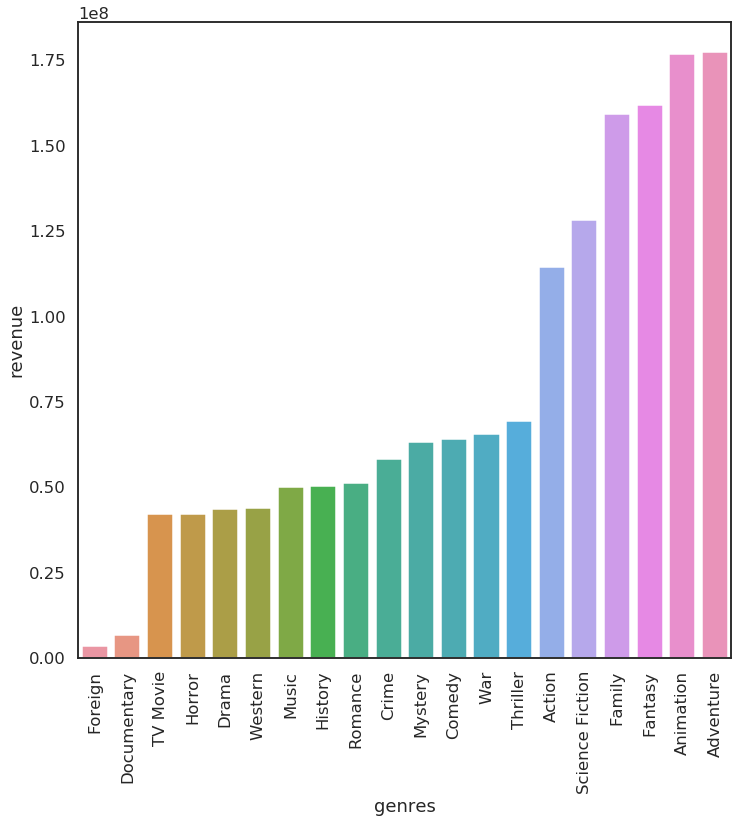

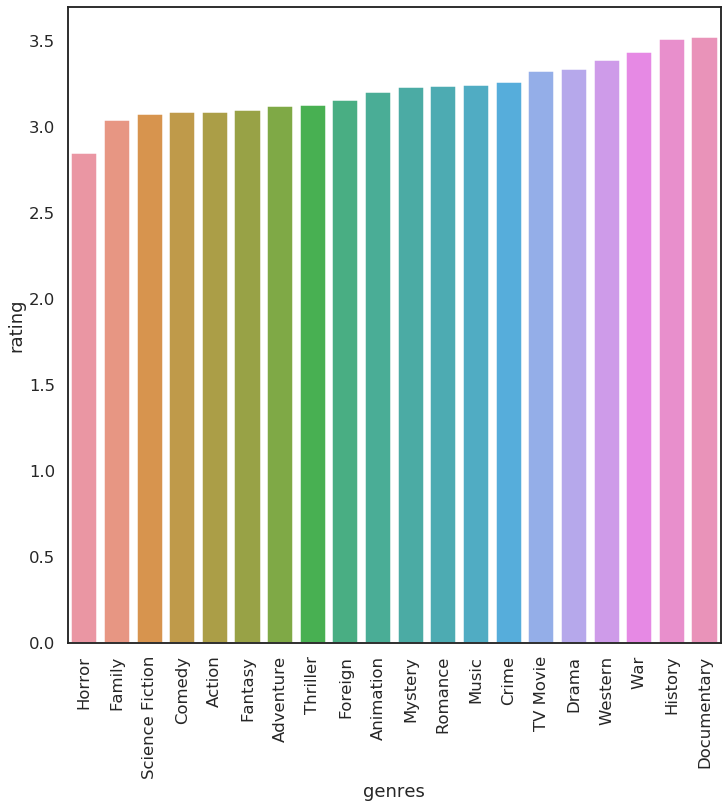

In [15]:
movies_with_revenue = explode(movies_with_revenue_query, ['revenue', 'title'])[['title','genres','revenue', 'rating']]
movies_with_revenue = explode(movies_with_revenue, ['genres'])
movies_with_revenue['rating'] = movies_with_revenue['rating'].apply(lambda x : x[0] if type(x) is list else x)

genres_rating_mean=movies_with_revenue.groupby(['genres'],as_index=False).mean().sort_values(by=['rating'])
genres_revenue_mean=movies_with_revenue.groupby(['genres'],as_index=False).mean().sort_values(by=['revenue'])

chart_revenue=sns.barplot(x=genres_revenue_mean['genres'],y=genres_revenue_mean['revenue'])
chart_revenue.set_xticklabels(labels=genres_revenue_mean['genres'], rotation=90)
plt.show()

chart_revenue=sns.barplot(x=genres_rating_mean['genres'],y=genres_rating_mean['rating'])
chart_revenue.set_xticklabels(labels=genres_rating_mean['genres'], rotation=90)
plt.show()

# Companies revenue and ratings

In [16]:
results = solrcon.search('*:*', fq=['revenue:[1 TO *]', 'production_companies:["" TO *]'], rows=50000)
query_df = pd.DataFrame(results.docs)
print(len(query_df))
movies_with_revenue = explode(query_df, ['revenue', 'title'])[['title','production_companies', 'rating', 'revenue']]
movies_with_revenue = explode(movies_with_revenue, ['production_companies'])
movies_with_revenue['rating'] = movies_with_revenue['rating'].apply(lambda x : x[0] if type(x) is list else x)

companies_raitng_mean=movies_with_revenue.groupby(['production_companies'],as_index=False).mean().sort_values(by=['rating'], ascending=False)
companies_revenue_mean=movies_with_revenue.groupby(['production_companies'],as_index=False).mean().sort_values(by=['revenue'], ascending=False)
companies_movies_counts=movies_with_revenue.groupby(['production_companies'],as_index=False).count().sort_values(by=['title'], ascending=False).head(20)

companies_with_several_movies_ratings = pd.merge(companies_raitng_mean,companies_movies_counts['production_companies'],on='production_companies',how='inner').sort_values(by=['rating'])
companies_with_several_movies_revenue = pd.merge(companies_revenue_mean,companies_movies_counts['production_companies'],on='production_companies',how='inner').sort_values(by=['revenue'])

6967


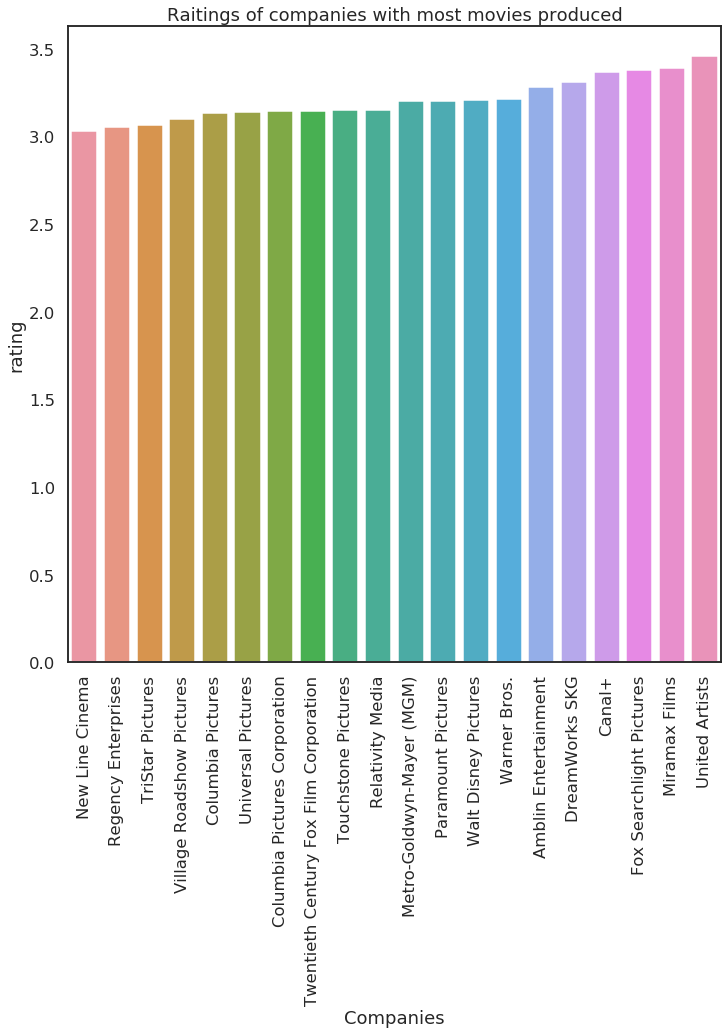

In [17]:
chart_companies_rating=sns.barplot(x=companies_with_several_movies_ratings['production_companies'],y=companies_with_several_movies_ratings['rating'])
chart_companies_rating.set_xticklabels(labels=companies_with_several_movies_ratings['production_companies'], rotation=90)
chart_companies_rating.set_title("Raitings of companies with most movies produced")
chart_companies_rating.set_xlabel("Companies")
plt.show()

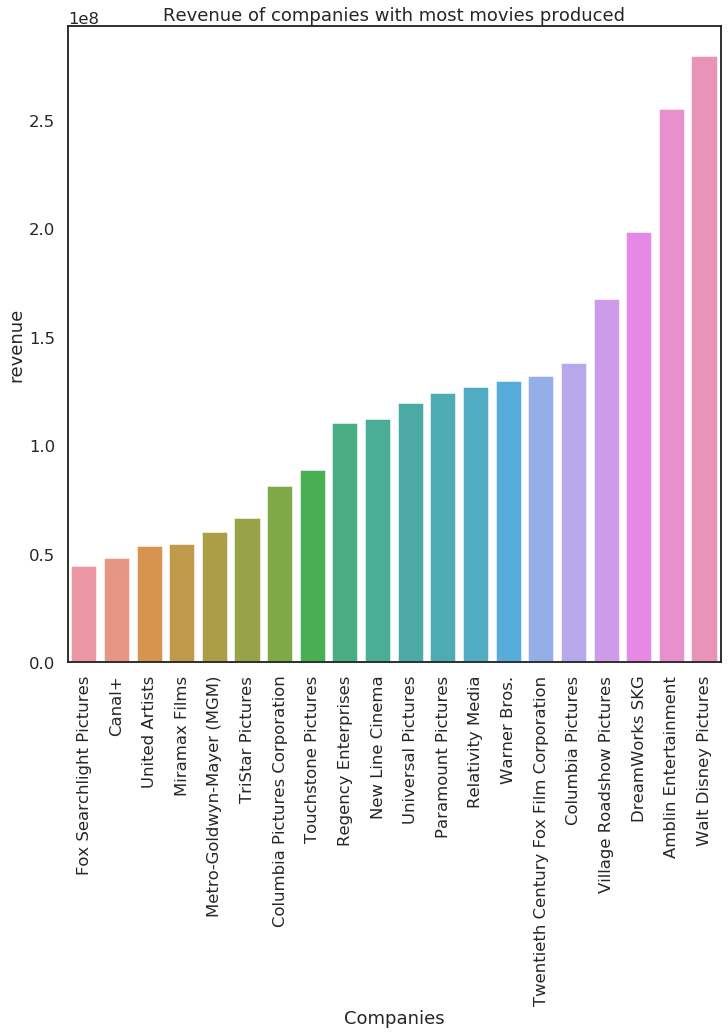

In [18]:
chart_companies_revenue=sns.barplot(x=companies_with_several_movies_revenue['production_companies'],y=companies_with_several_movies_revenue['revenue'])
chart_companies_revenue.set_xticklabels(labels=companies_with_several_movies_revenue['production_companies'], rotation=90)
chart_companies_revenue.set_title("Revenue of companies with most movies produced")
chart_companies_revenue.set_xlabel("Companies")
plt.show()

# Heatmaps

In [32]:
results = solrcon.search('*:*', fq=['revenue:[1 TO *]', 'production_companies:["" TO *]', 'genres:["" TO *]'], rows=50000)
query_df = pd.DataFrame(results.docs)
print(len(query_df))

6964


In [33]:
movies_with_revenue = explode(query_df, ['revenue', 'title'])[['title','production_companies', 'rating', 'revenue', 'genres']]
movies_with_revenue = explode(movies_with_revenue, ['production_companies'])
movies_with_revenue = explode(movies_with_revenue, ['genres'])
movies_with_revenue['rating'] = movies_with_revenue['rating'].apply(lambda x : x[0] if type(x) is list else x)

companies_and_genres_with_revenue = movies_with_revenue[['production_companies', 'genres', 'revenue']].groupby(['production_companies', 'genres'],as_index=False).mean().sort_values(by=['revenue'], ascending=False)
companies_and_genres_with_revenue = pd.merge(companies_and_genres_with_revenue,companies_with_several_movies_revenue['production_companies'].head(20),on='production_companies',how='inner').sort_values(by=['revenue'])

companies_and_genres_with_rating = movies_with_revenue[['production_companies', 'genres', 'rating']].groupby(['production_companies', 'genres'],as_index=False).mean().sort_values(by=['rating'], ascending=False)
companies_and_genres_with_rating = pd.merge(companies_and_genres_with_rating,companies_with_several_movies_ratings['production_companies'].head(20),on='production_companies',how='inner').sort_values(by=['rating'])


### Revenue of companies per genre

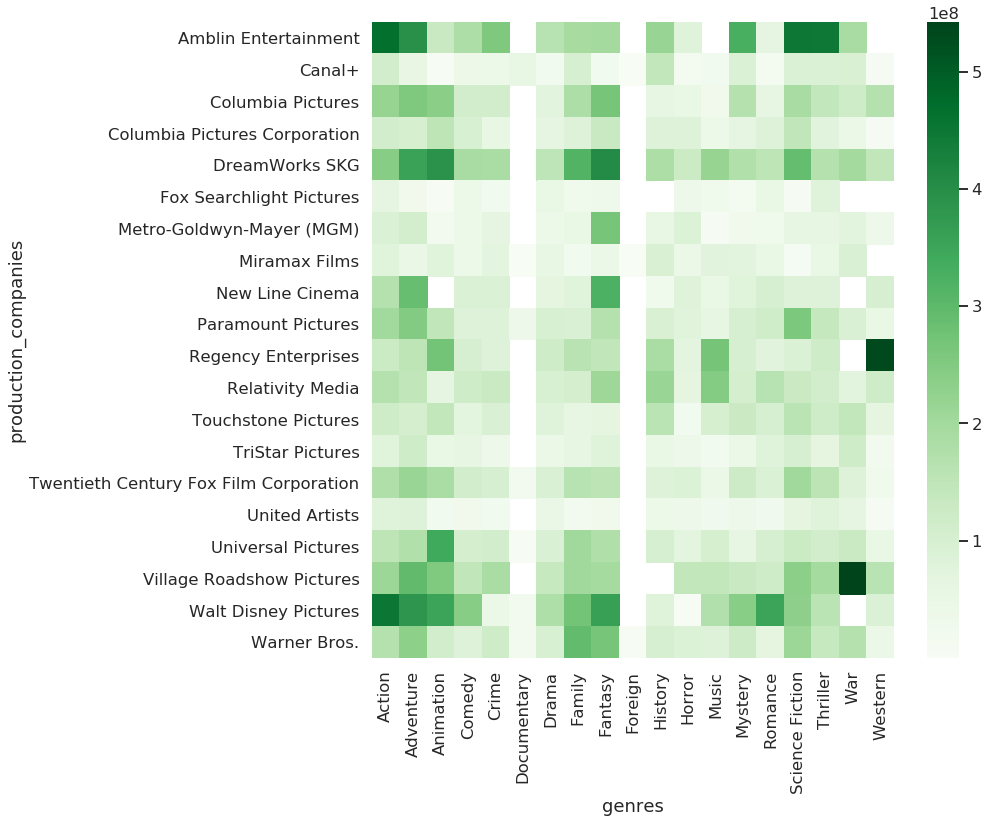

In [34]:
companies_and_genres_with_revenue = companies_and_genres_with_revenue.pivot("production_companies", "genres", "revenue")
ax = sns.heatmap(companies_and_genres_with_revenue, xticklabels=True, yticklabels=True, cmap="Greens")

### Ratings of companies per genre

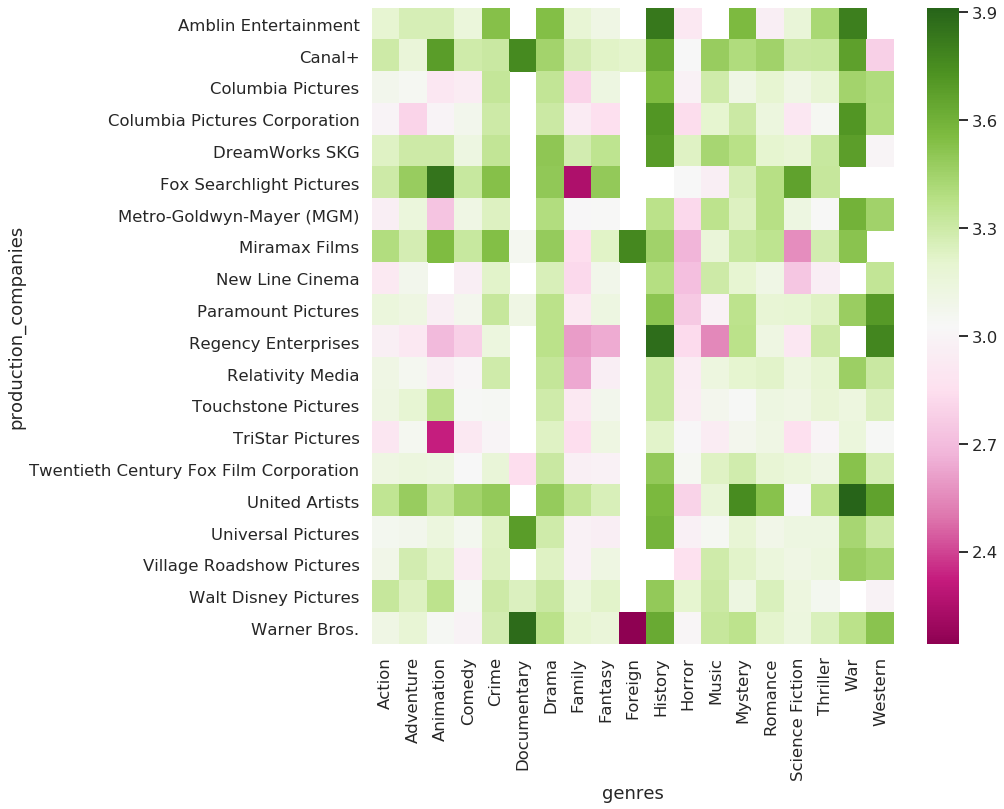

In [35]:
companies_and_genres_with_rating = companies_and_genres_with_rating.pivot("production_companies", "genres", "rating")
ax = sns.heatmap(companies_and_genres_with_rating, xticklabels=True, yticklabels=True, cmap="PiYG")